In [3]:

import cirq
import qsimcirq
import sympy 
import numpy as np
import matplotlib.pyplot as plt
# from google.colab.patches import cv2_imshow
import cv2
import tensorflow as tf


2024-08-23 10:05:18.132711: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-08-23 10:05:18.136156: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-08-23 10:05:18.146119: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-08-23 10:05:18.163200: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-08-23 10:05:18.168212: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-08-23 10:05:18.180927: I tensorflow/core/platform/cpu_feature_gu

# **Generator**

In [83]:

class GeneratorY:
    def __init__(self, image_shape, data_size = 3, no_partitions = 1, no_ancillary_qubits=1, no_blocks = 2) -> None:
        self.image_shape = image_shape
        self.data_size = data_size
        self.no_partitions = no_partitions
        self.no_qubits = no_ancillary_qubits + data_size
        self.no_blocks = no_blocks
        
        self.z = [sympy.Symbol(f'z_{i}') for i in range(self.no_qubits)]
        self.theta = [sympy.Symbol(f'θ_{i}') for i in range(no_partitions * no_blocks * self.no_qubits)]
        self.circuits = []
        self.outputs = []

        self.qubits = cirq.LineQubit.range(self.no_qubits)
        self._generate_circuits()
        
        qsim_options = qsimcirq.QSimOptions( cpu_threads=12, verbosity=1)
        self.simulator = qsimcirq.QSimSimulator(qsim_options)

    def _generate_circuits(self):
        extra = (self.image_shape[0] * self.image_shape[1]) % self.no_partitions
        out = (self.image_shape[0] * self.image_shape[1]) // self.no_partitions
        for i in range(self.no_partitions):
            
            circuit = cirq.Circuit()
            circuit.append(create_input_state(self.qubits,self.z))
            
            for j in range(self.no_blocks):
                start = (i * self.no_blocks *  self.no_qubits) + j *  self.no_qubits
                end = (i * self.no_blocks *  self.no_qubits) + (j+1) *  self.no_qubits
                circuit.append(blockY(self.qubits, self.no_qubits, self.theta[start:end]))
            self.outputs.append(out +( 1 if i < extra else 0))
            self.circuits.append(circuit)

    def generate_images(self, theta, n, no_repetitions = 100):
        resolved_circuits = []
        for i in range(self.no_partitions):
            start = (i * self.no_blocks *  self.no_qubits)
            end = ((i+1) * self.no_blocks *  self.no_qubits)
            # print(start,end)
            theta_mapping = [(self.theta[j], theta[j]) for j in range(start,end)]
            resolve_dict = dict(theta_mapping)

            resolver = cirq.ParamResolver(resolve_dict)
            resolved_circuit = cirq.resolve_parameters(self.circuits[i], resolver)
            if(no_repetitions > 0):
                resolved_circuit.append(measurments(self.qubits))
            resolved_circuits.append(resolved_circuit)
        final = []
        for _ in range(n):
            image = []
            z = np.random.normal(0,1,self.no_qubits) * np.pi
            for i in range(self.no_partitions):
                z_mapping = [(self.z[j], z[j]) for j in range(self.no_qubits)]
                start = (i * self.no_blocks *  self.no_qubits)
                end = ((i+1) * self.no_blocks *  self.no_qubits)
               
                resolve_dict = dict(z_mapping)

                resolver = cirq.ParamResolver(resolve_dict)
                resolved_circuit = cirq.resolve_parameters(resolved_circuits[i], resolver)

                
                if(no_repetitions > 0):
                    results = self.simulator.run(resolved_circuit, repetitions=no_repetitions)
                    d = results.histogram(key='M')
                    probs = np.zeros(2**self.no_qubits)
                    for val in d.keys():
                        probs[val] = d[val]/no_repetitions
                    
                    probs = probs[:(2**self.data_size)]
                    probs = probs/ np.sum(probs)
                    values = probs/ np.max(probs)
                    elements = [values[i] for i in range(self.outputs[i])]
                else:
                    results = self.simulator.simulate(resolved_circuit)
                    d = np.array(results.final_state_vector)
                    probs = np.abs(d)**2
                    probs = probs[:2**self.data_size]
                    probs = probs/ np.sum(probs)
                    values = probs/ np.max(probs)
                    elements = [values[i] for i in range(self.outputs[i])]
                image = image + elements
            
            image = np.reshape(image,self.image_shape)
            
            final.append(image)
        return final
    

class GeneratorXYZ:
    def __init__(self, image_shape, data_size = 3, no_partitions = 1, no_ancillary_qubits=1, no_blocks = 2) -> None:
        self.image_shape = image_shape
        self.data_size = data_size
        self.no_partitions = no_partitions
        self.no_qubits = no_ancillary_qubits + data_size
        self.no_blocks = no_blocks
        
        self.z = [sympy.Symbol(f'z_{i}') for i in range(self.no_qubits)]
        self.theta = [sympy.Symbol(f'θ_{i}') for i in range(no_partitions * no_blocks * (3 * self.no_qubits))]
        self.circuits = []
        self.outputs = []

        self.qubits = cirq.LineQubit.range(self.no_qubits)
        self._generate_circuits()
        
        qsim_options = qsimcirq.QSimOptions( cpu_threads=12, verbosity=1)
        self.simulator = qsimcirq.QSimSimulator(qsim_options)
        


    def _generate_circuits(self):
        extra = (self.image_shape[0] * self.image_shape[1]) % self.no_partitions
        out = (self.image_shape[0] * self.image_shape[1]) // self.no_partitions
        for i in range(self.no_partitions):
            
            circuit = cirq.Circuit()
            circuit.append(create_input_state(self.qubits,self.z))
            
            for j in range(self.no_blocks):
                start = (i * self.no_blocks * (3 * self.no_qubits)) + j * (3 * self.no_qubits)
                end = (i * self.no_blocks * (3 * self.no_qubits)) + (j+1) * (3 * self.no_qubits)
                circuit.append(blockXYZ(self.qubits, self.no_qubits, self.theta[start:end]))
            self.outputs.append(out +( 1 if i < extra else 0))
            self.circuits.append(circuit)

    def generate_images(self, theta, n, no_repetitions = 100):
        resolved_circuits = []
        for i in range(self.no_partitions):
            start = (i * self.no_blocks * (3 * self.no_qubits))
            end = ((i+1) * self.no_blocks * (3 * self.no_qubits))
            
            theta_mapping = [(self.theta[j], theta[j]) for j in range(start,end)]
            resolve_dict = dict(theta_mapping)

            resolver = cirq.ParamResolver(resolve_dict)
            resolved_circuit = cirq.resolve_parameters(self.circuits[i], resolver)
            if(no_repetitions > 0):
                resolved_circuit.append(measurments(self.qubits))
            resolved_circuits.append(resolved_circuit)
        final = []
        for _ in range(n):
            image = []
            z = np.random.normal(0,1,self.no_qubits) * np.pi
            for i in range(self.no_partitions):
                z_mapping = [(self.z[j], z[j]) for j in range(self.no_qubits)]
                start = (i * self.no_blocks * (3 * self.no_qubits))
                end = ((i+1) * self.no_blocks * (3 * self.no_qubits))
               
                resolve_dict = dict(z_mapping)

                resolver = cirq.ParamResolver(resolve_dict)
                resolved_circuit = cirq.resolve_parameters(resolved_circuits[i], resolver)
                
                if(no_repetitions > 0):
                    results = self.simulator.run(resolved_circuit, repetitions=no_repetitions)
                    d = results.histogram(key='M')
                    probs = np.zeros(2**self.no_qubits)
                    for val in d.keys():
                        probs[val] = d[val]/no_repetitions
                    
                    probs = probs[:(2**self.data_size)]
                    probs = probs/ np.sum(probs)
                    values = probs/ np.max(probs)
                    elements = [values[i] for i in range(self.outputs[i])]
                else:
                    results = self.simulator.simulate(resolved_circuit)
                    d = np.array(results.final_state_vector)
                    probs = np.abs(d)**2
                    probs = probs[:2**self.data_size]
                    probs = probs/ np.sum(probs)
                    values = probs/ np.max(probs)
                    elements = [values[i] for i in range(self.outputs[i])]
                image = image + elements
            
            image = np.reshape(image,self.image_shape)
            
            final.append(image)

        return final



def create_input_state(qubits,z):
    for i in range(len(z)):
        yield cirq.ry(z[i]).on(qubits[i])

def blockY(qubits, no_qubits, theta):
    for i in range(no_qubits):
        yield cirq.ry(theta[i]).on(qubits[i])
    for i in range(1,no_qubits):
        yield cirq.CZ(qubits[i-1],qubits[i])

def blockXYZ(qubits, no_qubits, theta):
    for i in range(no_qubits):
        yield cirq.rx(theta[i*3]).on(qubits[i])
        yield cirq.ry(theta[i]).on(qubits[i])
        yield cirq.rz(theta[i*3+2]).on(qubits[i])
    for i in range(1,no_qubits):
        yield cirq.CZ(qubits[i-1],qubits[i])

def measurments(qubits):
    yield cirq.measure(qubits, key='M')


# **Discriminator**

In [84]:
class Discriminator:
    def __init__(self, image_shape) -> None:
        self.image_shape = image_shape
        self.model = self._create_model()
        self.model.summary()
        

    def _create_model(self):
        input = tf.keras.Input(self.image_shape)
        layer = tf.keras.layers.Conv2D(16, (3,3), padding="same",activation=tf.nn.relu,kernel_initializer= tf.keras.initializers.HeUniform(),)(input)
        max_pool = tf.keras.layers.MaxPool2D((2,2))(layer)  
        flatten = tf.keras.layers.Flatten()(max_pool)
        output = tf.keras.layers.Dense(1, activation=tf.nn.sigmoid)(flatten)
        return tf.keras.Model(inputs=input, outputs=output)

    def predict(self, images, batch_size=32):
        return self.model.predict(images,batch_size = batch_size,verbose = 0)

# **Loss function**

In [85]:
def discriminator_loss(y_true, y_pred):
    return -tf.math.reduce_mean(y_true * tf.math.log(y_pred) + (1-y_true) * tf.math.log(1-y_pred))

def generator_loss(y_pred):
    return -np.mean(np.log(y_pred))

# **Compute Gradients**

In [86]:
def compute_gradients_generator(theta, generator, discriminator, batch_size=8, no_repetitions = 100):
    grads = np.zeros(len(theta))
    for i in range(len(theta)):
        theta_plus = np.array(theta)
        theta_plus[i] += np.pi/2
        # print(theta_plus - theta)
        images = np.array(generator.generate_images(theta_plus, batch_size, no_repetitions = no_repetitions))
        probs = discriminator.predict(images,batch_size = batch_size)
        loss_plus = generator_loss(probs)

        theta_minus = np.array(theta)
        theta_minus[i] -= np.pi/2
        images = np.array(generator.generate_images(theta_minus, batch_size, no_repetitions = no_repetitions))
        probs = discriminator.predict(images,batch_size = batch_size)
        loss_minus = generator_loss(probs)
        
        grads[i] += (loss_plus- loss_minus)/2
    return grads
    

# **Plot**

In [87]:
def grid_plot(images, epoch='', name='', n=3, save=False, scale=False):
    for index in range(n * n):
        plt.subplot(n, n, 1 + index)
        plt.axis('off')
        image = images[index]
        image = cv2.resize(image,(256,256),interpolation=cv2.INTER_AREA)
        plt.imshow(image,cmap='gray', vmin=0, vmax=1)
    fig = plt.gcf()
    fig.suptitle(name + '  '+ str(epoch), fontsize=14)
    if save:
        filename = 'results/generated_plot_e%03d_f.png' % (epoch+1)
        plt.savefig(filename)
        plt.close()
    plt.show()

# **Training procedure**

In [88]:
class Observer:
    def __init__(self) -> None:
        self.generator_loss = []
        self.discriminator_loss = []


def get_batch(generator, theta,  dataset, batch_size=32, no_repetitions = 100):

    batch_size //= 2 # Split evenly among fake and real samples

    fake_data = generator.generate_images(theta, batch_size, no_repetitions = no_repetitions)
    real_data = dataset[np.random.randint(0, dataset.shape[0], batch_size)]

    X = np.concatenate([fake_data, real_data], axis=0)
    y = np.concatenate([np.zeros([batch_size, 1]), np.ones([batch_size, 1])], axis=0)
    
    return X, y



def train_gan(theta, 
              generator, 
              discriminator, 
              dataset,
              learning_rate_generator = 0.3,
              learning_rate_discriminator = 0.01, 
              n_epochs=30, 
              batch_size=32, 
              no_repetitions = 100, 
              observer = None
              ):
    batches_per_epoch = int(len(dataset) / batch_size / 2)
    discriminator.model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate_discriminator),loss=discriminator_loss)
    
    for epoch in range(n_epochs):
        print(f"Epoch {epoch}")
        for batch in range(batches_per_epoch):
            print(f"Batch {batch}")
            X, y = get_batch(generator, theta, dataset, batch_size=batch_size, no_repetitions = no_repetitions)
            loss = discriminator.model.train_on_batch(X, y)
            if(observer is not None):
                observer.discriminator_loss.append(loss)
            print(f"Discriminator loss: {loss}")
           

            images = np.array(generator.generate_images(theta, batch_size, no_repetitions = no_repetitions))
            probs = discriminator.predict(images, batch_size = batch_size)
            loss = generator_loss(probs)
            if(observer is not None):
                observer.generator_loss.append(loss)
            print(f"Generator loss: {loss}")
            grads =  compute_gradients_generator(theta, generator, discriminator, batch_size = batch_size//2, no_repetitions = no_repetitions)
            # print(f"Grads: {grads}")
            theta -= learning_rate_generator * grads
       
        images = generator.generate_images(theta,9)
        grid_plot(images, epoch, name='GAN generated images', n=3, save=False)
    return theta

# **8x8  images of 0**

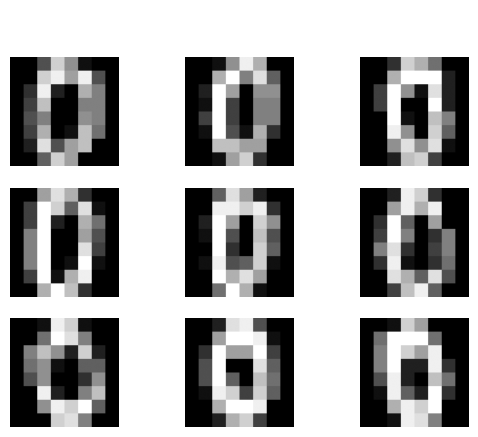

In [89]:
from sklearn.datasets import load_digits

mnist = load_digits()

data = []
for image,target in zip(mnist.data,mnist.target):
    if(target == 0):
        image = np.reshape(image/16,(8,8))
        # image = cv2.resize(image, (4,4),interpolation=cv2.INTER_AREA)
        data.append(image)
    
data = np.array(data)
grid_plot(data[:9],n=3)

Simulate for 1000 reps

In [90]:
gen = GeneratorXYZ( image_shape=(8,8), data_size = 4, no_partitions = 8, no_ancillary_qubits = 1, no_blocks = 2)
for circuit in gen.circuits:
    print(circuit)
    print("---------")

disc = Discriminator(image_shape=(8,8,1))

theta = np.random.rand(len(gen.theta)) *np.pi
print(len(theta))

0: ───Ry(z_0)───Rx(θ_0)────Ry(θ_0)───Rz(θ_2)────@───Rx(θ_15)───Ry(θ_15)───Rz(θ_17)──────────────@─────────────────────────────
                                                │                                               │
1: ───Ry(z_1)───Rx(θ_3)────Ry(θ_1)───Rz(θ_5)────@───@──────────Rx(θ_18)───Ry(θ_16)───Rz(θ_20)───@──────────@──────────────────
                                                    │                                                      │
2: ───Ry(z_2)───Rx(θ_6)────Ry(θ_2)───Rz(θ_8)────────@──────────@──────────Rx(θ_21)───Ry(θ_17)───Rz(θ_23)───@──────────@───────
                                                               │                                                      │
3: ───Ry(z_3)───Rx(θ_9)────Ry(θ_3)───Rz(θ_11)──────────────────@──────────@──────────Rx(θ_24)───Ry(θ_18)───Rz(θ_26)───@───@───
                                                                          │                                               │
4: ───Ry(z_4)───Rx(θ_12)───Ry(θ_4)───Rz(θ

In [91]:
observer = Observer()

theta = train_gan(theta,gen,disc,data,no_repetitions = 1000, n_epochs = 100, observer = observer)
disc.model.save_weights(f"simulate8x8/gen_weight")
np.save(f"simulate8x8/theta_final",theta)
np.save(f"simulate8x8/disc_loss_final",observer.discriminator_loss)
np.save(f"simulate8x8/gen_loss_final",observer.generator_loss)

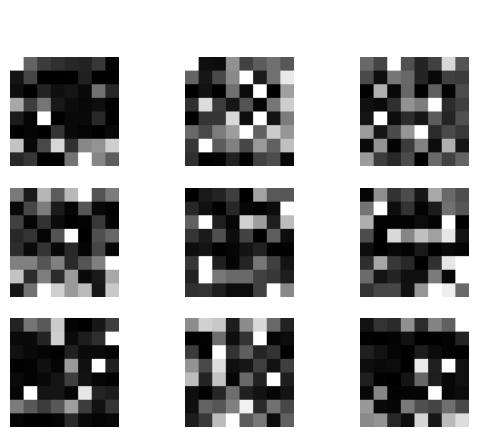

In [120]:
# theta = np.load("simulate8x8\\theta_final_2.npy")
images = gen.generate_images(theta,9,no_repetitions=1000)

grid_plot(images,n=3)


Using state-vector

In [106]:
gen = GeneratorXYZ( image_shape=(8,8), data_size = 4, no_partitions = 8, no_ancillary_qubits = 1, no_blocks = 2)
for circuit in gen.circuits:
    print(circuit)
    print("---------")

disc = Discriminator(image_shape=(8,8,1))

theta = np.random.rand(len(gen.theta)) *np.pi
print(len(theta))

0: ───Ry(z_0)───Rx(θ_0)────Ry(θ_0)───Rz(θ_2)────@───Rx(θ_15)───Ry(θ_15)───Rz(θ_17)──────────────@─────────────────────────────
                                                │                                               │
1: ───Ry(z_1)───Rx(θ_3)────Ry(θ_1)───Rz(θ_5)────@───@──────────Rx(θ_18)───Ry(θ_16)───Rz(θ_20)───@──────────@──────────────────
                                                    │                                                      │
2: ───Ry(z_2)───Rx(θ_6)────Ry(θ_2)───Rz(θ_8)────────@──────────@──────────Rx(θ_21)───Ry(θ_17)───Rz(θ_23)───@──────────@───────
                                                               │                                                      │
3: ───Ry(z_3)───Rx(θ_9)────Ry(θ_3)───Rz(θ_11)──────────────────@──────────@──────────Rx(θ_24)───Ry(θ_18)───Rz(θ_26)───@───@───
                                                                          │                                               │
4: ───Ry(z_4)───Rx(θ_12)───Ry(θ_4)───Rz(θ

In [94]:
observer = Observer()

theta = train_gan(theta,gen,disc,data,no_repetitions = 0, n_epochs = 100, observer = observer)
disc.model.save_weights(f"simulate8x8/gen_weight")
np.save(f"state_vector8x8/theta_final",theta)
np.save(f"state_vector8x8/disc_loss_final",observer.discriminator_loss)
np.save(f"state_vector8x8/gen_loss_final",observer.generator_loss)

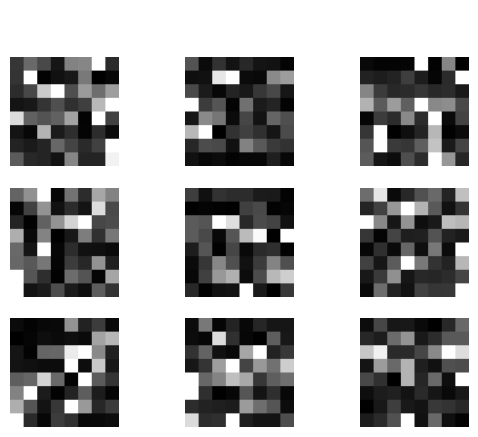

In [119]:
# theta = np.load("state_vector8x8\\theta_final_1.npy")
images = gen.generate_images(theta,9,no_repetitions=0)

grid_plot(images,n=3)


# **4x4  images of 1**

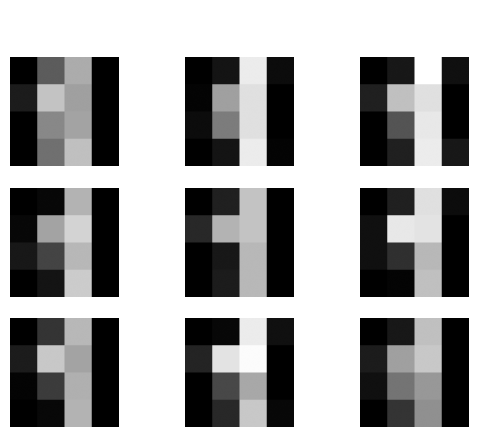

In [137]:
from sklearn.datasets import load_digits

mnist = load_digits()

data = []
for image,target in zip(mnist.data,mnist.target):
    if(target == 1):
        image = np.reshape(image/16,(8,8))
        image = cv2.resize(image, (4,4),interpolation=cv2.INTER_AREA)
        data.append(image)
    
data = np.array(data)
grid_plot(data[:9],n=3)

Simulate for 1000 reps

In [ ]:
gen = GeneratorY( image_shape=(4,4), data_size = 3, no_partitions = 4, no_ancillary_qubits = 1, no_blocks = 3)
for circuit in gen.circuits:
    print(circuit)
    print("---------")

disc = Discriminator(image_shape=(4,4,1))

theta = np.random.rand(len(gen.theta)) *np.pi
print(len(theta))

0: ───Ry(z_0)───Ry(θ_0)───@───Ry(θ_4)─────────────@─────────Ry(θ_8)─────────────@──────────────────
                          │                       │                             │
1: ───Ry(z_1)───Ry(θ_1)───@───@─────────Ry(θ_5)───@─────────@─────────Ry(θ_9)───@──────────@───────
                              │                             │                              │
2: ───Ry(z_2)───Ry(θ_2)───────@─────────@─────────Ry(θ_6)───@─────────@─────────Ry(θ_10)───@───@───
                                        │                             │                        │
3: ───Ry(z_3)───Ry(θ_3)─────────────────@─────────Ry(θ_7)─────────────@─────────Ry(θ_11)───────@───
---------
0: ───Ry(z_0)───Ry(θ_12)───@───Ry(θ_16)──────────────@──────────Ry(θ_20)──────────────@──────────────────
                           │                         │                                │
1: ───Ry(z_1)───Ry(θ_13)───@───@──────────Ry(θ_17)───@──────────@──────────Ry(θ_21)───@──────────@───────
                  

In [ ]:
observer = Observer()

theta = train_gan(theta,gen,disc,data,no_repetitions = 1000, n_epochs = 100, observer = observer)
disc.model.save_weights(f"simulate4x4/gen_weight")
np.save(f"simulate4x4/theta_final",theta)
np.save(f"simulate4x4/disc_loss_final",observer.discriminator_loss)
np.save(f"simulate4x4/gen_loss_final",observer.generator_loss)

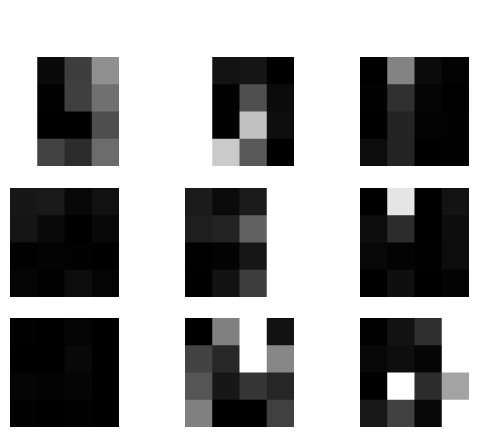

In [169]:
# theta = np.load("simulate4x4\\theta_final.npy")
images = gen.generate_images(theta,9,no_repetitions=1000)

grid_plot(images,n=3)

In [122]:
gen = GeneratorY( image_shape=(4,4), data_size = 3, no_partitions = 4, no_ancillary_qubits = 1, no_blocks = 3)
for circuit in gen.circuits:
    print(circuit)
    print("---------")

disc = Discriminator(image_shape=(4,4,1))

theta = np.random.rand(len(gen.theta)) *np.pi
print(len(theta))

0: ───Ry(z_0)───Ry(θ_0)───@───Ry(θ_4)─────────────@─────────Ry(θ_8)─────────────@──────────────────
                          │                       │                             │
1: ───Ry(z_1)───Ry(θ_1)───@───@─────────Ry(θ_5)───@─────────@─────────Ry(θ_9)───@──────────@───────
                              │                             │                              │
2: ───Ry(z_2)───Ry(θ_2)───────@─────────@─────────Ry(θ_6)───@─────────@─────────Ry(θ_10)───@───@───
                                        │                             │                        │
3: ───Ry(z_3)───Ry(θ_3)─────────────────@─────────Ry(θ_7)─────────────@─────────Ry(θ_11)───────@───
---------
0: ───Ry(z_0)───Ry(θ_12)───@───Ry(θ_16)──────────────@──────────Ry(θ_20)──────────────@──────────────────
                           │                         │                                │
1: ───Ry(z_1)───Ry(θ_13)───@───@──────────Ry(θ_17)───@──────────@──────────Ry(θ_21)───@──────────@───────
                  

In [97]:
observer = Observer()

theta = train_gan(theta,gen,disc,data,no_repetitions = 0, n_epochs = 100, observer = observer)
disc.model.save_weights(f"simulate4x4/gen_weight")
np.save(f"simulate4x4/theta_final",theta)
np.save(f"simulate4x4/disc_loss_final",observer.discriminator_loss)
np.save(f"simulate4x4/gen_loss_final",observer.generator_loss)

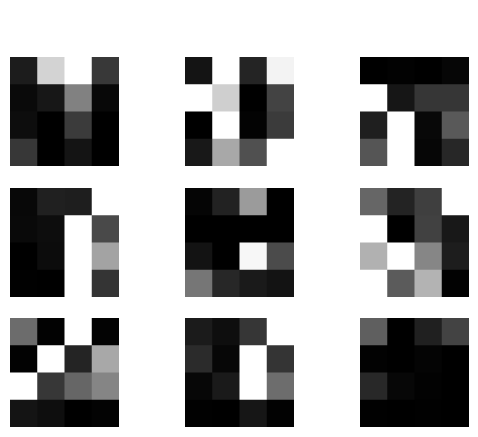

In [209]:
# theta = np.load("state_vector4x4\\theta_final.npy")
images = gen.generate_images(theta,9,no_repetitions=0)

grid_plot(images,n=3)